In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', None)  # отобразить все колонки
plt.style.use('seaborn-v0_8-whitegrid')

In [4]:
df = pd.read_csv('../../data/_data.csv')

### Оригинальная выгрузка включает 23368 строк и 25 уникальных параметров

In [5]:
df.shape

(23368, 25)

In [6]:
df.columns

Index(['Unnamed: 0', 'ID  объявления', 'Количество комнат', 'Тип', 'Метро',
       'Адрес', 'Площадь, м2', 'Дом', 'Парковка', 'Цена', 'Телефоны',
       'Описание', 'Ремонт', 'Площадь комнат, м2', 'Балкон', 'Окна', 'Санузел',
       'Можно с детьми/животными', 'Дополнительно', 'Название ЖК',
       'Серия дома', 'Высота потолков, м', 'Лифт', 'Мусоропровод',
       'Ссылка на объявление'],
      dtype='object')

### Выгрузка содержит жилые объекты в Москве, Санкт-Петербуеге и Краснадарском крае

Для дальнейшего анализа взяты данные по г. Москва.

In [7]:
# проверка на наличие других городов: сначала выделяем город
df['Город'] = df['Адрес'].str.split(',').str[0].str.strip()
# Затем группируем по городу
df.groupby('Город').size().reset_index(name='количество')

,Город,количество
0,Краснодарский край,603
1,Москва,19737
2,Санкт-Петербург,3028


In [8]:
# Фильтруем изначальный датасет по Москве
df = df[df['Город'] == 'Москва']

In [9]:
df["Цена за месяц"] = df["Цена"].str.split(" ").str[0].astype(float).astype(int) #выводим чистую колонку с информацией о цене за месяц в int

# Графики

## 1. График распредления стоимости аренды за месяц (без выбросов)

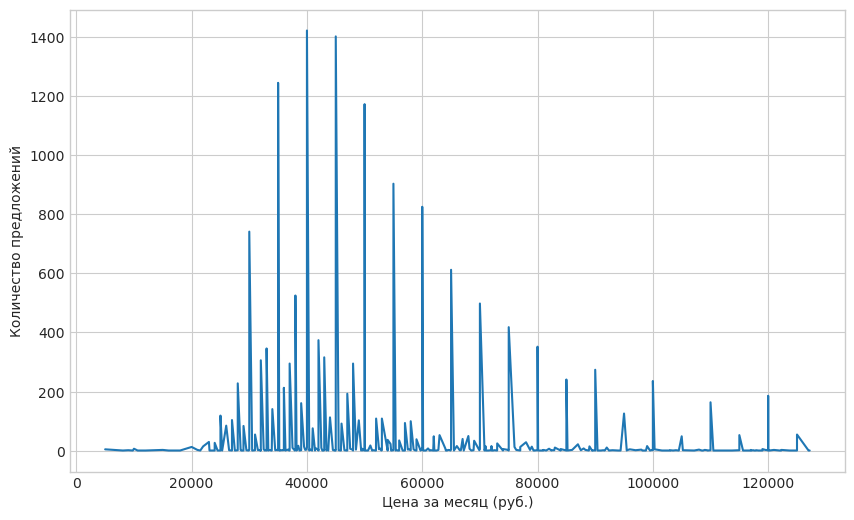

In [10]:
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    return data[(data[column] >= Q1 - 1.5 * IQR) & (data[column] <= Q3 + 1.5 * IQR)]

filtered_df = remove_outliers_iqr(df, "Цена за месяц")

counts = filtered_df['Цена за месяц'].value_counts().sort_index()

plt.figure(figsize=(10,6))
sns.lineplot(x=counts.index, y=counts.values)
plt.xlabel('Цена за месяц (руб.)')
plt.ylabel('Количество предложений')
plt.show();

## 2. Топ-20 ЖК по количеству предложений аренды

In [11]:
df["Название ЖК чистое"] = df["Название ЖК"].str.split(",").str[0] #добавление новой колонки с "чистым" названием ЖК без года
df["ЖК год"] = df["Название ЖК"].str.split(",").str[1] # год строительства ЖК

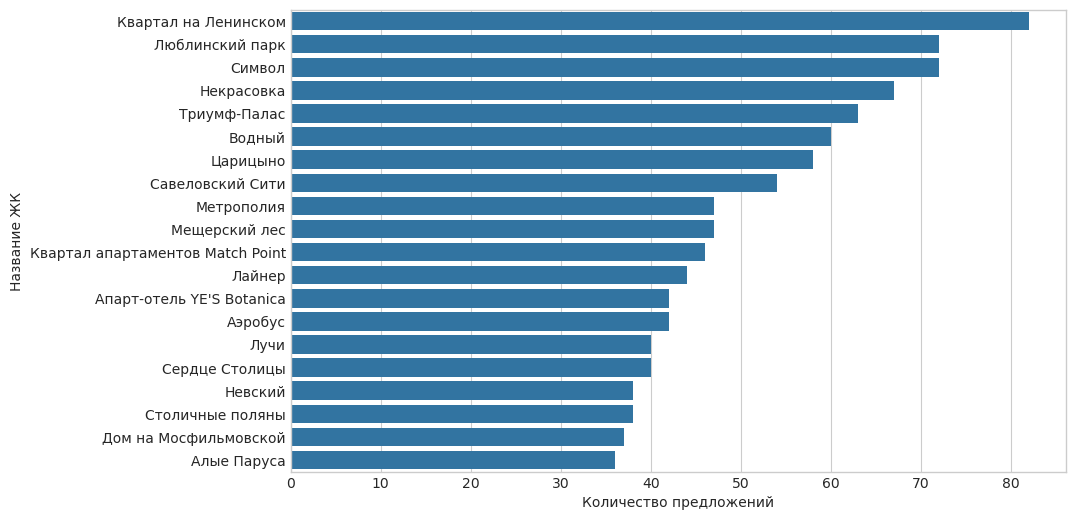

In [12]:
top_jk = df['Название ЖК чистое'].value_counts().nlargest(20)

plt.figure(figsize=(10,6))
sns.barplot(x=top_jk.values, y=top_jk.index) #, hue=top_jk.index, palette="deep")
plt.xlabel('Количество предложений')
plt.ylabel('Название ЖК')
plt.show();

## 3. Распределение предложений по общей площади (в квадратных метрах)

In [13]:
df['Общая площадь'] = df['Площадь, м2'].str.split('/').str[0].astype(float) # создала новую колонку с Общей площадью квартиры (float)

<Figure size 640x480 with 0 Axes>

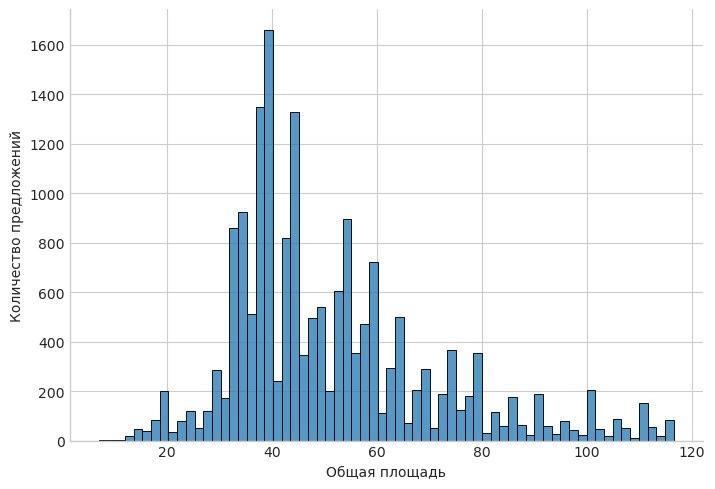

In [19]:
Q1 = df['Общая площадь'].quantile(0.25)
Q3 = df['Общая площадь'].quantile(0.75)
IQR = Q3 - Q1
#фильтруем площадь внутри "внутреннего интерквартильного диапазона"
filtered_df = df[(df['Общая площадь'] >= Q1 - 1.5*IQR) & (df['Общая площадь'] <= Q3 + 1.5*IQR)]

plt.figure()
sns.displot(data=filtered_df, x='Общая площадь', aspect=1.45)
plt.ylabel("Количество предложений");

## 4. Распределение предложений по типу квартиры (количество комнат)

В выборке представлены 1-6 комнатные квартиры. 56% относятся к категории 1-2х комантных квартир.  

В 535 квартирах отсутствует инфомрация о количестве комнат. 

In [15]:
df[['rooms_qty', 'room_type']] = df['Количество комнат'].str.split(',', expand=True) # создали два столбца, оба str
df['rooms_qty'] = df['rooms_qty'].str.strip().fillna(0).astype(int) # заполнили отсутствующие данные 0 и привели тип к int
df['room_type'] = df['room_type'].str.strip() # убрали лишние пробелы

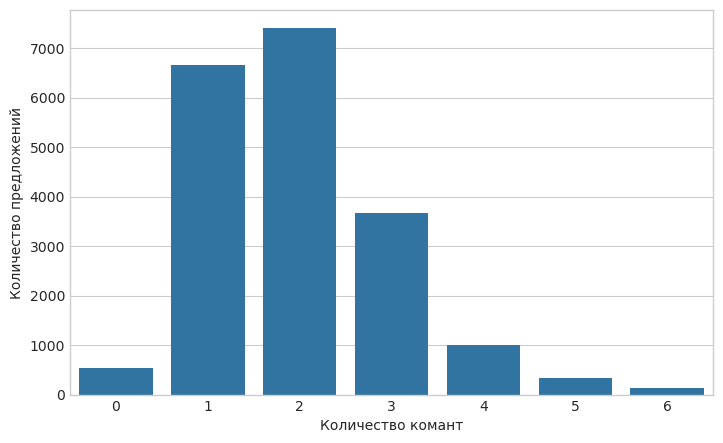

In [16]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(8.3, 5))
sns.countplot(data=df, x='rooms_qty');
plt.xlabel('Количество комант')
plt.ylabel('Количество предложений');

## 5. Зависимость стоимости аренды жилья в месяц от его общей площади

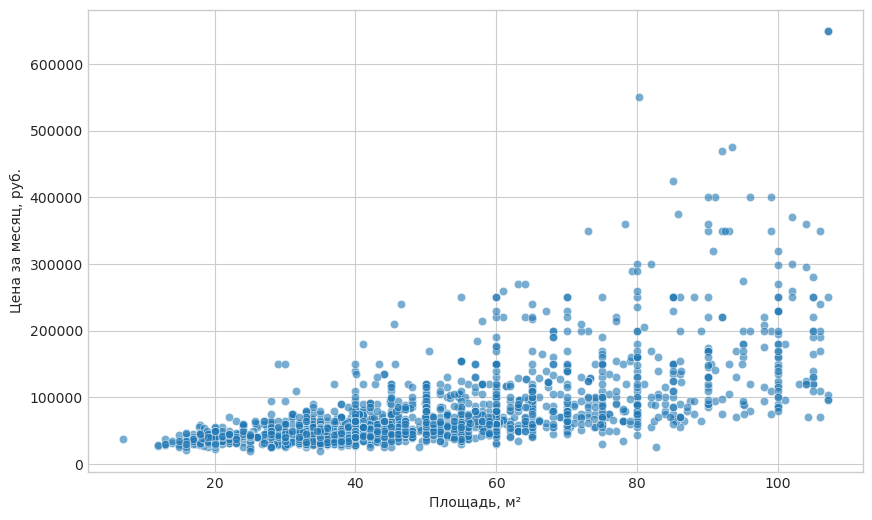

In [20]:
# Приводим к числовому виду
df["Цена за месяц"] = pd.to_numeric(df["Цена за месяц"], errors="coerce")
df["Площадь, м2"] = pd.to_numeric(df["Площадь, м2"], errors="coerce")

filtered_df = remove_outliers_iqr(filtered_df, "Площадь, м2")

# Строим график
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_df,
    x="Площадь, м2",
    y="Цена за месяц",
    alpha=0.6
)
plt.xlabel("Площадь, м²")
plt.ylabel("Цена за месяц, руб.")
plt.grid(True)
plt.show()

## 6. Распределение по ремонту

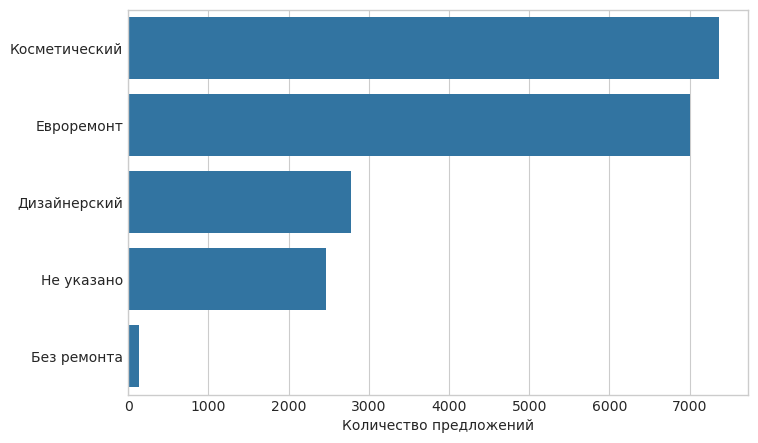

In [21]:
counts = df['Ремонт'].value_counts(dropna=False)

labels = counts.index.to_series().replace({np.nan: 'Не указано'})

plt.figure(figsize=(8,5))
sns.barplot(x=counts.values, y=labels) #, hue=labels, palette="viridis")
plt.xlabel('Количество предложений')
plt.ylabel('')
plt.show()

## 7. График предложений с разрешением/запретом на аренду с детьми или животными

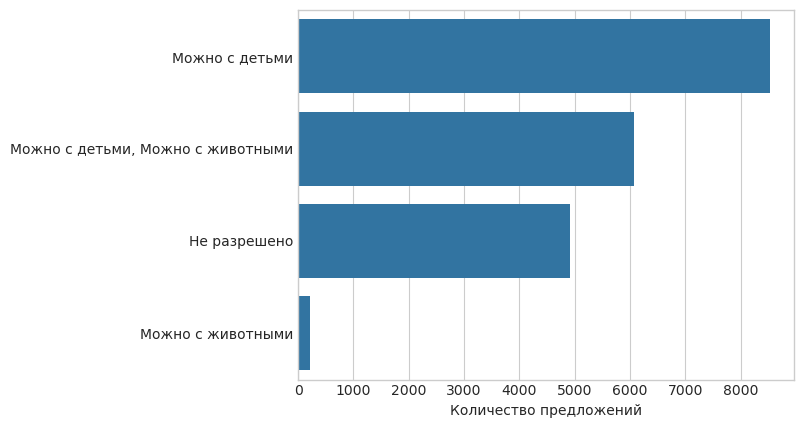

In [22]:
#количество предложений можно с животными/детьми

counts = df['Можно с детьми/животными'].value_counts(dropna=False)

labels = counts.index.to_series().replace({np.nan: 'Не разрешено'})

plt.figure()
sns.barplot(x=counts.values, y=labels) #, hue=labels, palette="Set2")
plt.xlabel('Количество предложений')
plt.ylabel('')
plt.show()

In [23]:
df[['Станция', 'Путь до метро']] = df['Метро'].str.extract(r'м\.\s*([^\(]+)\s*\((.*)\)').apply(lambda x: x.str.strip())  # Выделили станции Метро

## 8. Топ 10 станций Метро

График отражает топ станций метро по количеству расположенных рядом объектов

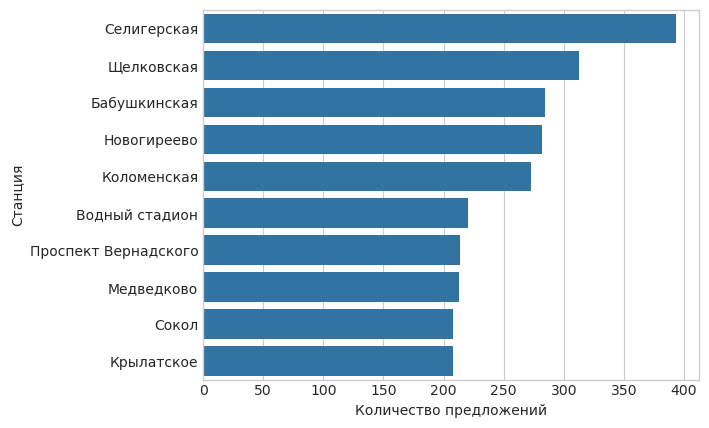

In [24]:
top10subway = df['Станция'].value_counts().nlargest(10).index
df_top10subway = df[df['Станция'].isin(top10subway)]
top10_counts = df_top10subway['Станция'].value_counts()

plt.figure()
sns.countplot(data=df_top10subway, y='Станция', order=top10_counts.index)
plt.xlabel("Количество предложений");

In [25]:
# Импорт датсета с информаицей о метро
metro = pd.read_excel('../../data/final_metro.xlsx', index_col=0)
# Форматирование df['Станция'] для исключения вероятности несопоставления ключей
df['Станция'] = df['Станция'].str.title()
df['Станция'] = df['Станция'].str.replace('ё', 'е')

In [26]:
# Объединение основного датафрейма с информацией о линиях метро и районах
df = df.merge(metro, how='left', left_on='Станция', right_on='Station')

In [27]:
# Группировка для графика по районам
popular_districts = df.groupby('District', as_index=False).agg({'ID  объявления': 'count'}).sort_values('ID  объявления', ascending=False).head(10)

## 9. Топ 10 районов по предложению аренды

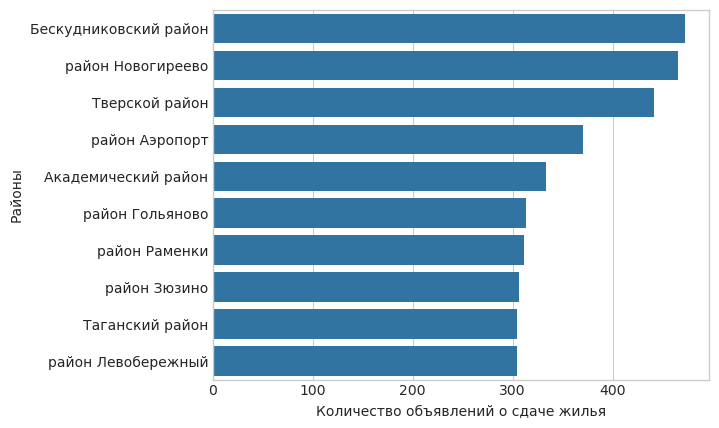

In [28]:
fig, ax = plt.subplots()
sns.barplot(popular_districts, x='ID  объявления', y='District')
ax.set_xlabel('Количество объявлений о сдаче жилья')
ax.set_ylabel('Районы');

In [29]:
df.to_csv('../../data/_data.with_new_cols.csv', index=False)